# Udacity 机器学习(进阶)毕业项目

## 走神司机识别

### 第1步：数据探索
#### 进行数据的统计学分析

In [1]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

#进行配置，每个GPU使用60%上限现存
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 使用编号为1，2号的GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # 每个GPU现存上届控制在60%以内
session = tf.Session(config=config)

# 设置session
KTF.set_session(session )

Using TensorFlow backend.


In [1]:
from sklearn.datasets import load_files, load_sample_images
from keras.utils import np_utils
import os
import numpy as np
from glob import glob
from preprocess import *
import random
from pprint import pprint

random.seed(876543)

#定义函数来加载train和test数据集
def load_datasets(path):
    '''
    加载给定的路径目录下的文件，
    以每个文件夹名字为target name并将其下的文件归入该target类别，
    train_files, test_flies：是包含了图像的文件路径的numpy数组
    train_targets, test_targets：是包含了分类标签经过独热编码后的numpy数组
    target是独热编码后的numpy数组
    '''
    data = load_files(path)
    files = np.array(data['filenames'])
    print(files)
    print(data['target'])
    targets = np_utils.to_categorical(np.array(data['target']),10)
    return files, targets

root_path = "../../../data/distracted_driver_detection/unzip_data/imgs/"

#加载train和test数据集
train_files, train_targets = load_datasets(root_path + 'train')
test_files, test_targets = load_datasets(root_path + 'test')
#os.listdir：输出的文件名不包括"images/test"
#glob：输出的文件名包括"images/test"
#为了与load_datasets的输出保持一致，这里使用glob
#test_files = np.array(os.listdir('images/test2/test/'))
#test_files = np.array(glob('images/test2/test/*'))
driver_status = [item[64:-1] for item in sorted(glob(root_path + "train/*/"))]

print(driver_status)
#打印数据的统计描述
print("There are %d total driver status." % len(driver_status))
print("There are %d total driver images.\n" % len(np.hstack([train_files, test_files])))

print("There are %d total train driver images." % len(train_files))
print("There are %d total test driver images." % len(test_files))

#print(train_files)
print(train_targets)
# print(test_files)
#print(driver_status)

Using TensorFlow backend.


['../../../data/distracted_driver_detection/unzip_data/imgs/train/c9/img_54.jpg'
 '../../../data/distracted_driver_detection/unzip_data/imgs/train/c1/img_94750.jpg'
 '../../../data/distracted_driver_detection/unzip_data/imgs/train/c9/img_90465.jpg'
 ...
 '../../../data/distracted_driver_detection/unzip_data/imgs/train/c4/img_2632.jpg'
 '../../../data/distracted_driver_detection/unzip_data/imgs/train/c4/img_62157.jpg'
 '../../../data/distracted_driver_detection/unzip_data/imgs/train/c1/img_18002.jpg']
[9 1 9 ... 4 4 1]
['../../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_48438.jpg'
 '../../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_49454.jpg'
 '../../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_94120.jpg'
 ...
 '../../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_57211.jpg'
 '../../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_58315.jpg'
 '../../../data/distracted_driver_detection/un

#### 进行数据的可视化
训练集中有22424张照片，已经按照类别将图片分类好了，下面统计了在训练数据中每种类型的样本数量，从统计结果来看，每种状态下的样本数量基本相同，在2000～2500张照片左右；测试集有79721张图片。图片的尺寸都是640*480。

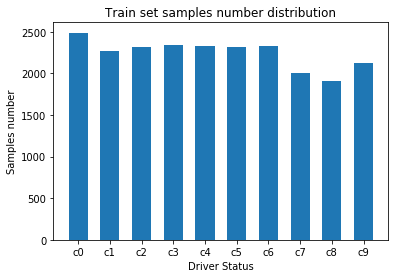

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
train_class_sample_num=[]

for n_class_dir in sorted(glob(root_path + "train/*/")):
    sample_num = len(glob(n_class_dir+'*'))
    train_class_sample_num.append(sample_num)
    
ind = np.arange(len(driver_status))
plt.bar(ind, train_class_sample_num, 0.6)
plt.xlabel('Driver Status')
plt.ylabel('Samples number')
plt.xticks(ind,driver_status)
plt.title('Train set samples number distribution')
plt.show()



项目还提供了一张与训练集图片对应的subject (driver) id，和class id的表格，从该表格中可以得到每个司机在不同分类中的数量。从下面的统计结果来看，p050,p051,p072号司机的状态分布与其他的有所不同，且各占总样本数量的3.5%，4.1%，1.5%，数量比较少在后面的训练中可以考虑去除。

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


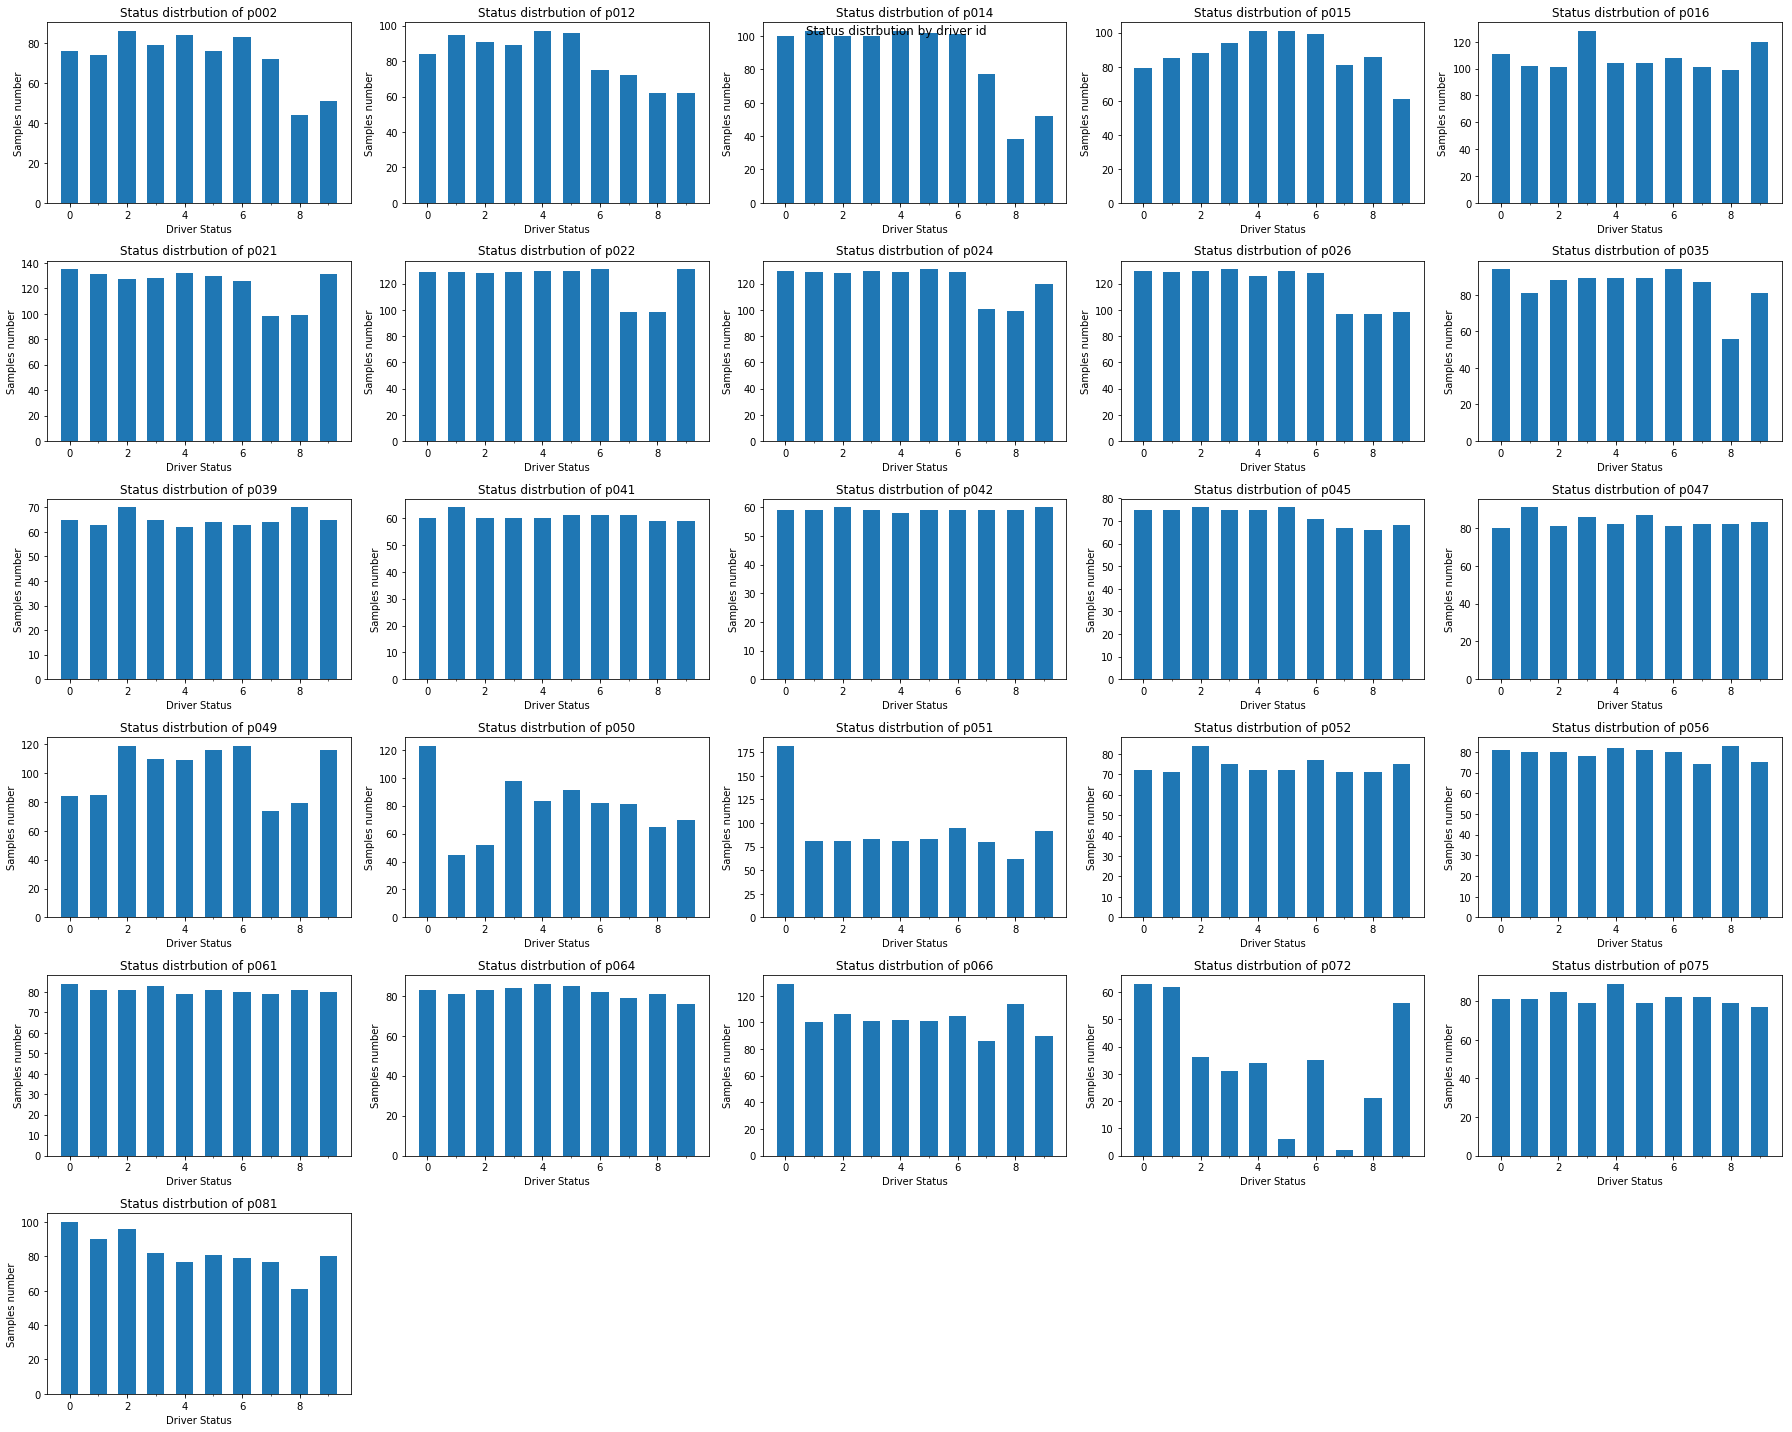

In [4]:
import pandas as pd

driver_list_data = pd.read_csv('../../../data/distracted_driver_detection/unzip_data/driver_imgs_list.csv')

#司机编号
driver_id = []

#所有样本数量
sample_num = driver_list_data['subject'].size

for i in range(sample_num):
    if not driver_list_data['subject'][i] in driver_id:
        driver_id.append(driver_list_data['subject'][i])
fig = plt.figure(figsize=(25,20))
for i in range(len(driver_id)):
    ax=fig.add_subplot(6,5,i+1)
    #表示每种状态下的样本数量
    sample_num_temp = []
    for class_name in driver_status:
        sample_num_temp.append(driver_list_data[(driver_list_data.subject == driver_id[i]) & (driver_list_data.classname == class_name)].shape[0])
    ax.bar(ind, sample_num_temp, 0.6)
    ax.set_xlabel('Driver Status')
    ax.set_ylabel('Samples number')
    ax.set_xticks(ind,driver_status)
    ax.set_title('Status distrbution of %s'%(driver_id[i]))
fig.suptitle('Status distrbution by driver id')
fig.tight_layout()
fig.show()
#print(driver_list_data[(driver_list_data.subject == 'p050')].shape[0]/sample_num)
#print(driver_list_data[(driver_list_data.subject == 'p051')].shape[0]/sample_num)
#print(driver_list_data[(driver_list_data.subject == 'p072')].shape[0]/sample_num)

### 第2步：建立模型
#### 实现一个简单的CNN网络
- 本项目采用巻积神经网络来识别司机的状态，采用keras框架，Tensorlow作为后端来搭建CNN网络。CNN的输入是一个4维张量，为(n_samples, rows, columns, channels)。其中n_samples表示样本的总数，rows, columns和channels分别表示图像的行数、列数和通道数。
- 下面是将图片进行预处理，转化为CNN网络的输入。


In [5]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path, img_nrows = None, img_ncols = None):
    # 用PIL加载RGB图像为PIL.Image.Image类型,将图像尺寸缩放到target_size
    #img_nrows,img_ncols: Either NULL (default to original size) or integer vector (img_height, img_width).
    img = image.load_img(img_path, target_size = (img_nrows,img_ncols))
    # 将PIL.Image.Image类型转化为格式为(img_nrows,img_ncols, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, target_size, 3)的4维张量并返回
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths, img_nrows = None, img_ncols = None):
    list_of_tensor = [path_to_tensor(img_path, img_nrows, img_ncols) for img_path in tqdm(img_paths)]
    #返回(n_samples, target_size, 3)的4维张量
    return np.vstack(list_of_tensor)

In [6]:
#读取图像得到tensor，并进行归一化处理
from preprocess import *
from sklearn.utils import shuffle

train_tensors = paths_to_tensor(train_files,img_nrows = 224, img_ncols = 224).astype('float32')/255

from keras.preprocessing.image import ImageDataGenerator
 
gen = ImageDataGenerator(rescale = 1/255)
print(root_path + 'test')
test_generator = gen.flow_from_directory(root_path + 'test', (224,224), shuffle=False, batch_size=32)
test_file_names = test_generator.filenames

print(train_tensors.shape[1:])
print(test_generator)
#print(train_targets)
# print(test_file_names)


100%|██████████| 22424/22424 [03:43<00:00, 100.26it/s]


../../../data/distracted_driver_detection/unzip_data/imgs/test
Found 79726 images belonging to 1 classes.
(224, 224, 3)


In [8]:
#这里的模型结构参考了P5的dog project中推荐的CNN网络家架构。主要目的是为了验证整个程序的流程是否正确。
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential

simple_model = Sequential()
simple_model.add(Conv2D(filters = 16, kernel_size=(2,2),strides=(1,1), padding='valid', input_shape = train_tensors.shape[1:]))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(Conv2D(filters = 32, kernel_size=(2,2),strides=(1,1), padding='valid'))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(Conv2D(filters = 64, kernel_size=(2,2),strides=(1,1), padding='valid'))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(GlobalAveragePooling2D())
simple_model.add(Dropout(rate=0.5))
simple_model.add(Dense(10,activation='softmax'))
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [8]:
#from keras.utils import multi_gpu_model
#simple_parallel_model = multi_gpu_model(simple_model, gpus=2)
#编译模型
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#simple_parallel_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# 画出模型的结构图
from keras.utils import plot_model
import pydot
plot_model(simple_model, to_file='simple_model.png',show_shapes = True)

In [10]:
#下面使用model checkpointing来存储具有最低验证集loss的模型，并将训练过程中的
from keras.callbacks import ModelCheckpoint, CSVLogger

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_best_models/simple_model_best_weights.hdf5', 
                               verbose=1, save_best_only=True)
csv_logger = CSVLogger('log/simple_model_fit.log')
simple_model.fit(train_tensors, train_targets, 
          validation_split=0.2,shuffle=True,
          epochs=epochs, batch_size=20, callbacks=[checkpointer,csv_logger], verbose=1)


Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 11s 638us/step - loss: 2.3029 - acc: 0.1128 - val_loss: 2.2990 - val_acc: 0.1159

Epoch 00001: val_loss improved from inf to 2.29901, saving model to saved_best_models/simple_model_best_weights.hdf5
Epoch 2/10
17939/17939 [==============================] - 10s 543us/step - loss: 2.2953 - acc: 0.1200 - val_loss: 2.2890 - val_acc: 0.1329

Epoch 00002: val_loss improved from 2.29901 to 2.28901, saving model to saved_best_models/simple_model_best_weights.hdf5
Epoch 3/10
17939/17939 [==============================] - 10s 542us/step - loss: 2.2852 - acc: 0.1332 - val_loss: 2.2799 - val_acc: 0.1369

Epoch 00003: val_loss improved from 2.28901 to 2.27990, saving model to saved_best_models/simple_model_best_weights.hdf5
Epoch 4/10
17939/17939 [==============================] - 10s 543us/step - loss: 2.2721 - acc: 0.1467 - val_loss: 2.2499 - val_acc: 0.1679

Epoch 00004: val_loss improved f

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


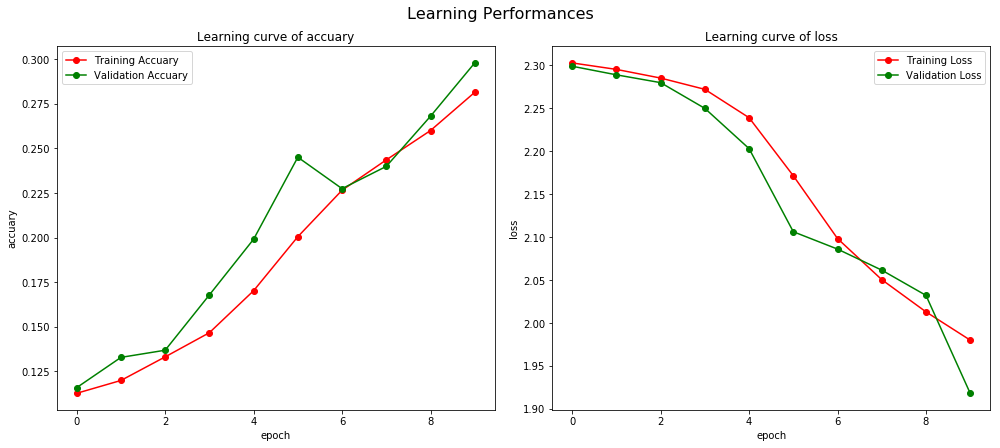

In [11]:
#画出学习曲线
import visuals as vs
vs.ModelLearning('log/simple_model_fit.log')


In [12]:
#加载具有最佳验证集loss的模型权重
simple_model.load_weights('saved_best_models/simple_model_best_weights.hdf5')

In [13]:
#生成可提交的submission file
from submission import *

simple_model_predictions = simple_model.predict_generator(test_generator, len(test_generator),verbose=1)
create_submission('simple_model',simple_model_predictions, root_path)

Found 0 images belonging to 0 classes.


#### 使用迁移学习
从上面的结果来看，simple model这个简单的CNN网络架构并不能实现很好的结果。主要是从学习曲线可以看出模型处于underfitting状态。
这里采用迁移学习来实现更大的网络结构

In [9]:
#利用迁移模型创建一个CNN网络
from preprocess import *
get_bottleneck_features_from_ResNet50(root_path)
#get_bottleneck_features_from_InceptionV3('images')
#get_bottleneck_features_from_Xception('images')
#get_bottleneck_features_from_InceptionResNetV2('images')

Found 22424 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
get_image_tensors done


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


MemoryError: 

In [2]:
from resnet50 import *

resnet50_model = train_ResNet50(root_path)

Found 22424 images belonging to 10 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 activatio

In [2]:
from resnet50 import *

inceptionv3_model = train_InceptionV3(root_path)

Found 22424 images belonging to 10 classes.
87916544/87910968 [==============================] - 1s 0us/step
0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 ave

176/176 [==============================] - 447s 3s/step - loss: 1.4826 - acc: 0.3645
Epoch 23/70
176/176 [==============================] - 447s 3s/step - loss: 1.3977 - acc: 0.3590
Epoch 24/70
176/176 [==============================] - 448s 3s/step - loss: 1.2945 - acc: 0.3929
Epoch 25/70
176/176 [==============================] - 448s 3s/step - loss: 1.3099 - acc: 0.4259
Epoch 26/70
176/176 [==============================] - 447s 3s/step - loss: 1.2312 - acc: 0.4379
Epoch 27/70
176/176 [==============================] - 451s 3s/step - loss: 1.1348 - acc: 0.4483
Epoch 28/70
176/176 [==============================] - 454s 3s/step - loss: 1.1697 - acc: 0.4792
Epoch 29/70
176/176 [==============================] - 453s 3s/step - loss: 1.0611 - acc: 0.5138
Epoch 30/70
176/176 [==============================] - 446s 3s/step - loss: 0.9141 - acc: 0.6528
Epoch 31/70
176/176 [==============================] - 453s 3s/step - loss: 0.7878 - acc: 0.6792
Epoch 32/70
176/176 [=====================

载入特征向量

In [32]:
import h5py
from sklearn.utils import shuffle
np.random.seed(5000)

print(root_path)

with h5py.File('data/ResNet50.h5') as f:
    train_data = np.array(f['train'])
    test_data = np.array(f['test'])
    target_data = np_utils.to_categorical(np.array(f['target']),10)
    
train_ResNet50,target_ResNet50 = shuffle(train_data, target_data)
test_ResNet50 = test_data
    

print(train_ResNet50[0].shape)
# print(train_ResNet50.shape)
# print(train_ResNet50.shape[1:])
print(len(train_ResNet50))
print(test_data.shape)
# print(target_ResNet50)
print(target_data)

../../../data/distracted_driver_detection/unzip_data/imgs/


MemoryError: 

构建模型

In [22]:
from keras.models import *
from keras.layers import *

np.random.seed(5000)

from keras import optimizers

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06)

model_params_dict = dict(
    optimizer=adam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

#input_tensor = Input(train_ResNet50.shape[1:])
#x = Dropout(0.5)(input_tensor)
#x = Dense(10,activation = 'sigmoid')(x)
#resnet50_model = Model(input_tensor,x)
#resnet50_model.summary()

resnet50_model = Sequential()
resnet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
resnet50_model.add(Dropout(rate=0.5))
resnet50_model.add(Dense(10, activation='softmax'))

resnet50_model.summary()
resnet50_model.compile(**model_params_dict)

3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [23]:
## 训练模型
from keras.callbacks import ModelCheckpoint, CSVLogger

epochs = 80
best_model_path = 'saved_best_models/my_resnet50_adam_model_best_weights.hdf5'
best_model_log_path = 'log/resnet50_adam_model_fit.log'

checkpointer = ModelCheckpoint(filepath=best_model_path, 
                               verbose=1, save_best_only=True)
csv_logger = CSVLogger(best_model_log_path)
#print(target_ResNet50)
resnet50_model.fit(train_ResNet50, target_ResNet50, 
          validation_split=0.2,shuffle=True,
          epochs=epochs, batch_size=128, callbacks=[checkpointer,csv_logger], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/80
17939/17939 [==============================] - 5s 281us/step - loss: 2.9272 - acc: 0.1390 - val_loss: 1.9492 - val_acc: 0.3313

Epoch 00001: val_loss improved from inf to 1.94925, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 2/80
17939/17939 [==============================] - 4s 216us/step - loss: 2.4102 - acc: 0.2178 - val_loss: 1.5937 - val_acc: 0.5458

Epoch 00002: val_loss improved from 1.94925 to 1.59368, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 3/80
17939/17939 [==============================] - 4s 216us/step - loss: 2.0259 - acc: 0.3128 - val_loss: 1.3351 - val_acc: 0.6740

Epoch 00003: val_loss improved from 1.59368 to 1.33508, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 4/80
17939/17939 [==============================] - 4s 216us/step - loss: 1.7455 - acc: 0.3976 - val_loss: 1.1513 - val_acc: 0.7420

Epoch 

17939/17939 [==============================] - 4s 215us/step - loss: 0.3676 - acc: 0.8891 - val_loss: 0.1916 - val_acc: 0.9616

Epoch 00062: val_loss improved from 0.19311 to 0.19158, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 63/80
17939/17939 [==============================] - 4s 215us/step - loss: 0.3632 - acc: 0.8903 - val_loss: 0.1881 - val_acc: 0.9659

Epoch 00063: val_loss improved from 0.19158 to 0.18812, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 64/80
17939/17939 [==============================] - 4s 218us/step - loss: 0.3712 - acc: 0.8856 - val_loss: 0.1862 - val_acc: 0.9666

Epoch 00064: val_loss improved from 0.18812 to 0.18616, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 65/80
17939/17939 [==============================] - 4s 215us/step - loss: 0.3544 - acc: 0.8895 - val_loss: 0.1843 - val_acc: 0.9652

Epoch 00065: val_loss improved from 0.18616 to 0.18433, sav

In [24]:
## 加载具有最好验证loss的模型

resnet50_model.load_weights('saved_best_models/my_resnet50_adam_model_best_weights.hdf5')


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


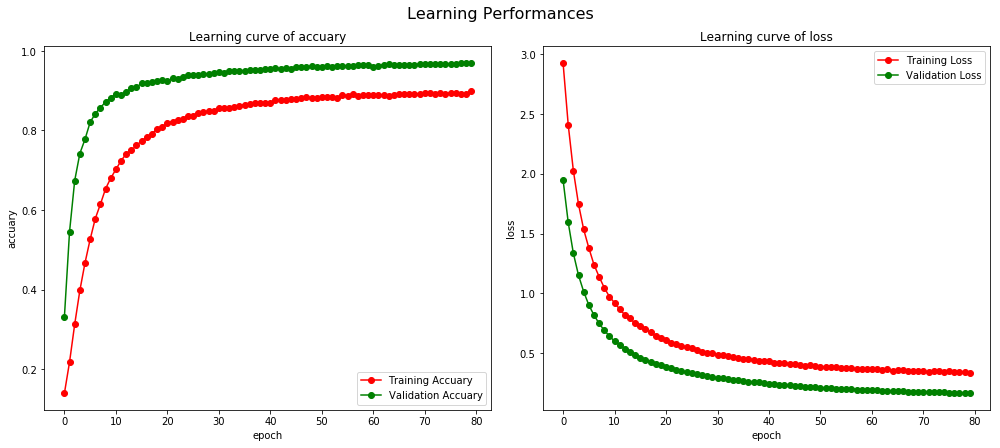

In [27]:
import visuals as vs
#使用adam优化起
vs.ModelLearning('log/resnet50_adam_model_fit.log')

In [31]:
print(train_ResNet50.shape)

print("start prediction")
# resnet50_model_predictions = resnet50_model.predict(test_ResNet50, verbose=1)
print("complete prediction")


(22424, 7, 7, 2048)
start prediction
complete prediction


In [3]:
import h5py
from keras.models import *
from keras.layers import *
np.random.seed(5000)
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
from keras.applications.resnet50 import ResNet50, preprocess_input

ImageFile.LOAD_TRUNCATED_IMAGES = True

test_files = root_path + 'test'
image_size = (224,224)
gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = gen.flow_from_directory(test_files, image_size, shuffle=False, batch_size=128)

inceptionv3_model_predictions = inceptionv3_model.predict_generator(test_generator, verbose=1)

Found 79726 images belonging to 1 classes.
623/623 [==============================] - 879s 1s/step


In [5]:
#生成可提交的submission file
from submission import *
create_submission('inceptionv3_model_trainable',inceptionv3_model_predictions, root_path)

Found 79726 images belonging to 1 classes.


In [5]:
resnet50_model.save_weights('weights/resnet50_model_trainable.h5')